In [1]:
import tensorflow
tensorflow.__version__

'2.4.1'

In [2]:
import random
random.seed(0)
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
import os
os.chdir("E:\PGPMLAI\Project 9")
os.getcwd()

'E:\\PGPMLAI\\Project 9'

#### Import the dataset

In [6]:
TRAIN_DATA = 'Part 1- Train data - images.npy'
IMAGE_SIZE = 128
HEIGHT_CELLS = 64
WIDTH_CELLS = 64

In [7]:
import numpy as np
from matplotlib import pyplot as plt
X = np.load(TRAIN_DATA, allow_pickle=True)

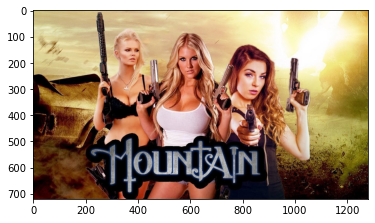

In [8]:
plt.imshow(X[100][0])

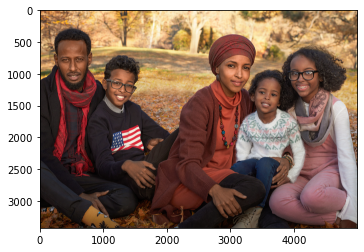

In [18]:
plt.imshow(X[12][0])

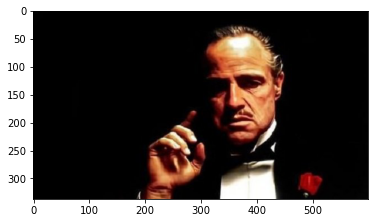

In [10]:
plt.imshow(X[10][0])

In [11]:
!pip3 install scikit-image
!pip3 install opencv-python

#### creating training dataset images with mask image for faces.

In [12]:
import skimage.transform as st
from PIL import Image

y_train = []
y_train_box = []
X_train = []
X_train_img = []

for x in X:
    img = st.resize(x[0], (IMAGE_SIZE, IMAGE_SIZE, 3))
    image_height = x[1][0]['imageHeight']
    image_width = x[1][0]['imageWidth']
    X_train.append(np.array([img,image_height,image_width]))
    X_train_img.append(img)
    mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)
    y_train_faces = []
    for index, row in enumerate(x[1]):
        y_train_face = []
        faces = row['points']
        x0 = faces[0]['x'] * IMAGE_SIZE
        y0 = faces[0]['y'] * IMAGE_SIZE
        x1 = faces[1]['x'] * IMAGE_SIZE
        y1 = faces[1]['y'] * IMAGE_SIZE
        y_train_face.append(x0)
        y_train_face.append(y0)
        y_train_face.append(x1)
        y_train_face.append(y1)
        y_train_faces.append(np.array(y_train_face))      
        mask[int(y0):int(y1),int(x0):int(x1)] = 255       
    y_train_box.append(y_train_faces) 
    mask = st.resize(mask, (HEIGHT_CELLS, WIDTH_CELLS))
    y_train.append(mask)

In [13]:
X_train = np.array(X_train)
X_train_img = np.array(X_train_img)
y_train = np.array(y_train)
y_train_box = np.array(y_train_box)

In [14]:
print(X.shape)
print(X_train.shape)
print(y_train[0].shape)

(409, 2)
(409, 3)
(64, 64)


#### visualising some sample images with mask image for faces.

In [15]:
def plot_sample(index):
    import matplotlib.patches as patches
    unscaled = X_train[index]
    regions = y_train_box[index]
    image_height = unscaled[1]
    image_width = unscaled[2]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(st.resize(unscaled[0], (image_height, image_width)))
    ax2.imshow(st.resize(y_train[index], (image_height, image_width)))
    for region in regions:
        x0 = int(region[0] * image_width/ IMAGE_SIZE)
        y0 = int(region[1] * image_height/ IMAGE_SIZE)
        x1 = int(region[2] * image_width/ IMAGE_SIZE)
        y1 = int(region[3] * image_height/ IMAGE_SIZE)
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)
    plt.show()

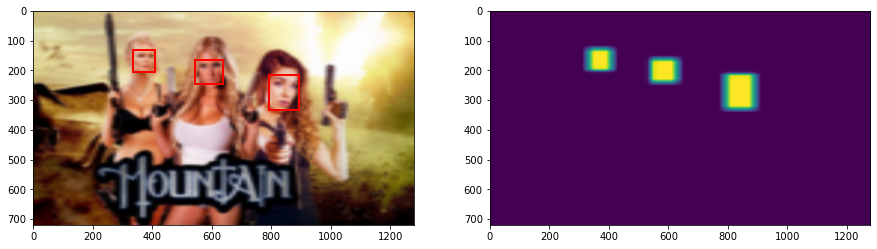

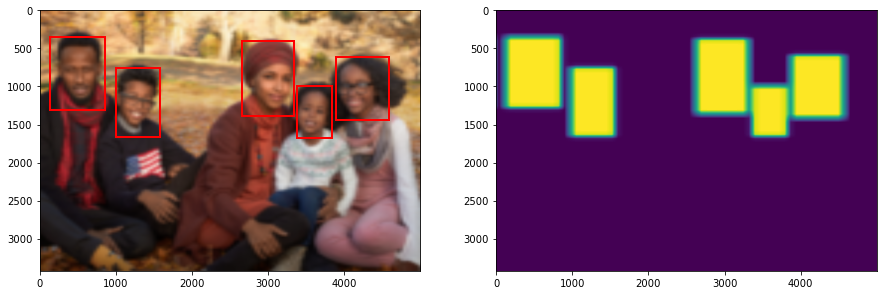

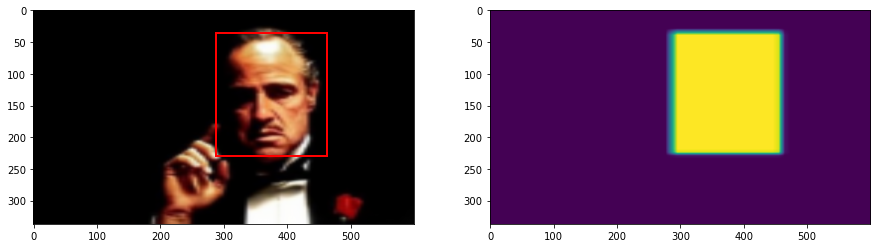

In [17]:
plot_sample(100)
plot_sample(12)
plot_sample(10)

####  splitIng the data into train and val

In [19]:
seed = 42
from sklearn.model_selection import train_test_split
X_train_img, X_val_img, y_train, y_val = train_test_split(X_train_img, y_train, test_size=0.1, random_state=seed)

#### Using pretrained model for creating face mask detection model

In [20]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_3_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_11_relu").output
    block5 = model.get_layer("conv_pw_13_relu").output
    
    x = Concatenate()([UpSampling2D()(block5), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)
    
    return Model(inputs=model.input, outputs=x)

In [21]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [22]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [23]:
ALPHA = 1
model = create_model(False)
model.summary()

17227776/17225924 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 64, 64, 32)   0           conv1_bn[0][0]                   
_____________________________

In [24]:
from tensorflow.keras.losses import binary_crossentropy

model.compile('Adam', loss=loss, metrics=[dice_coefficient])

In [25]:
import tensorflow as tf

model.fit(tf.convert_to_tensor(X_train_img), y_train, epochs=40, batch_size=32, 
          validation_data=(X_val_img, y_val))

Epoch 1/40
12/12 [==============================] - 98s 8s/step - loss: 2.0560 - dice_coefficient: 0.3663 - val_loss: 4.1945 - val_dice_coefficient: 0.0624
Epoch 2/40
12/12 [==============================] - 80s 7s/step - loss: 0.8446 - dice_coefficient: 0.5981 - val_loss: 2.9479 - val_dice_coefficient: 0.1748
Epoch 3/40
12/12 [==============================] - 76s 6s/step - loss: 0.6795 - dice_coefficient: 0.6493 - val_loss: 3.1635 - val_dice_coefficient: 0.1583
Epoch 4/40
12/12 [==============================] - 77s 6s/step - loss: 0.5574 - dice_coefficient: 0.6959 - val_loss: 3.5261 - val_dice_coefficient: 0.1167
Epoch 5/40
12/12 [==============================] - 80s 7s/step - loss: 0.5040 - dice_coefficient: 0.7158 - val_loss: 2.9408 - val_dice_coefficient: 0.1683
Epoch 6/40
12/12 [==============================] - 79s 7s/step - loss: 0.4580 - dice_coefficient: 0.7438 - val_loss: 2.2715 - val_dice_coefficient: 0.2555
Epoch 7/40
12/12 [==============================] - 75s 6s/step 

#### Testing the model

In [26]:
model.evaluate(X_val_img, y_val)

2/2 [==============================] - 2s 365ms/step - loss: 0.9149 - dice_coefficient: 0.5739


[0.9148681163787842, 0.5738801956176758]

####  using prediction image to show our prediction

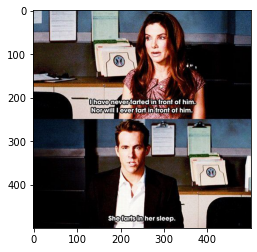

In [30]:
# test image
filename = 'Part 1Test Data - Prediction Image.jpeg'
plt.imshow(plt.imread(filename))

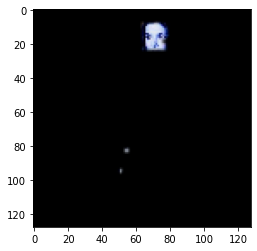

In [27]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input


unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))

feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_SIZE,IMAGE_SIZE))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)